# TRUSTED ZONE - QUALITY REPORT

In [1]:
import json
import boto3
from collections import Counter
import matplotlib.pyplot as plt
import statistics
import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv())

True

## Connect to MinIO

In [2]:
s3_client = boto3.client(
    "s3",
    endpoint_url="http://localhost:9000",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

## Get JSON files from Formatted zone

In [3]:
def get_json(s3_client, bucket, prefix):
    json_object = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
    key = json_object['Contents'][0]['Key'] # shold be only one file of steam and steamspy in formatted
    response = s3_client.get_object(Bucket=bucket, Key=key)
    file_content = response['Body'].read().decode('utf-8')
    data = json.loads(file_content)
    return data

In [4]:
steam_json = get_json(
    s3_client=s3_client, 
    bucket=os.getenv("FORMATTED_ZONE_BUCKET"),
    prefix="json/steam/"
)

steamspy_json = get_json(
    s3_client=s3_client, 
    bucket=os.getenv("FORMATTED_ZONE_BUCKET"),
    prefix="json/steamspy/"
)

## Integrity Check
### Check unique game ids

In [5]:
def check_duplicate_ids(data_dict, dataset_name):
    num_entries = len(data_dict)
    num_unique_keys = len(data_dict.keys()) 

    if num_entries == num_unique_keys:
        print(f"{dataset_name}: Confirmed. All {num_entries} game_ids are unique.")
        return True
    else:
        print(f"{dataset_name}: Found duplicate game_ids! This indicates an issue with data loading or structure. "
                      f"Number of entries ({num_entries}) does not match number of unique keys ({num_unique_keys}).")
        return False

In [6]:
steam_ids_unique = check_duplicate_ids(steam_json, "Steam")
steamspy_ids_unique = check_duplicate_ids(steamspy_json, "SteamSpy")

Steam: Confirmed. All 100 game_ids are unique.
SteamSpy: Confirmed. All 100 game_ids are unique.


### Check games in both datasets, unique in Steam, and unique in SteamSpy

In [7]:
def compare_dataset_ids(steam_data_dict, steamspy_data_dict):
    steam_ids = set(steam_data_dict.keys())
    steamspy_ids = set(steamspy_data_dict.keys())

    common_ids = steam_ids.intersection(steamspy_ids)
    only_steam_ids = steam_ids.difference(steamspy_ids)
    only_steamspy_ids = steamspy_ids.difference(steam_ids) 

    num_common = len(common_ids)
    num_only_steam = len(only_steam_ids)
    num_only_steamspy = len(only_steamspy_ids)

    return num_common, num_only_steam, num_only_steamspy

In [8]:
common, steam_only, steamspy_only = compare_dataset_ids(steam_json, steamspy_json)
print(f"Number of games in both datasets: {common}")
print(f"Number of games only in Steam: {steam_only}")
print(f"Number of games only in SteamSpy: {steamspy_only}")

Number of games in both datasets: 100
Number of games only in Steam: 0
Number of games only in SteamSpy: 0


### Define important attributes to analyze

In [9]:
STEAM_IMPORTANT_KEYS = [
    "name", "release_date", "required_age", "price", "dlc_count",
    "detailed_description", "about_the_game", "header_image", "windows", "mac", "linux",
    "metacritic_score", "achievements", "recommendations", "developers",
    "publishers", "categories", "genres"
]

STEAMSPY_IMPORTANT_KEYS = [
    "positive", "negative", "estimated_owners", "average_playtime_forever",
    "median_playtime_forever", "tags"
]

### Check missing values

In [10]:
def remove_missing_important_fields(data_dict, important_keys, dataset_name):
    if not data_dict:
        print(f"Input {dataset_name} dictionary is empty or None. Returning None.")
        return None

    entries_to_remove = []
    missing_reasons = Counter()
    total_checked = len(data_dict)

    print(f"Checking {total_checked} entries in {dataset_name} for missing important fields...")

    for game_id, game_data in data_dict.items():
        missing_fields_for_entry = []
        for key in important_keys:
            value = game_data.get(key) 
            if value is None or value == "" or value == []:
                missing_fields_for_entry.append(key)

        if missing_fields_for_entry:
            entries_to_remove.append(game_id)
            for field in missing_fields_for_entry:
                missing_reasons[field] += 1

    num_removed = len(entries_to_remove)
    num_remaining = total_checked - num_removed
    print(f"{num_removed} entries ({num_removed/total_checked:.1%}) from {dataset_name} has missing important fields.")
    print(f"{num_remaining} entries remain in {dataset_name}.")

    if missing_reasons:
        print(f"Breakdown of missing fields causing removal in {dataset_name}:")
        for field, count in missing_reasons.most_common(5):
            print(f"  - Field '{field}' was missing {count} times.")

In [11]:
remove_missing_important_fields(steam_json, STEAM_IMPORTANT_KEYS, "Steam")
print()
remove_missing_important_fields(steamspy_json, STEAMSPY_IMPORTANT_KEYS, "SteamSpy")

Checking 100 entries in Steam for missing important fields...
3 entries (3.0%) from Steam has missing important fields.
97 entries remain in Steam.
Breakdown of missing fields causing removal in Steam:
  - Field 'about_the_game' was missing 1 times.
  - Field 'release_date' was missing 1 times.
  - Field 'genres' was missing 1 times.

Checking 100 entries in SteamSpy for missing important fields...
0 entries (0.0%) from SteamSpy has missing important fields.
100 entries remain in SteamSpy.


## Check data types
Now we build a map to define the proper data type for each field:

In [12]:
STEAM_EXPECTED_TYPES = {
    "price": (float,),
    "required_age": (int,),
    "dlc_count": (int,),
    "windows": (bool,),
    "mac": (bool,),
    "linux": (bool,),
    "metacritic_score": (int,),
    "achievements": (int,),
    "recommendations": (int,),
    "supported_languages": (list,),
    "full_audio_languages": (list,),
    "packages": (list,),
    "developers": (list,),
    "publishers": (list,),
    "categories": (list,),
    "genres": (list,),
    "screenshots": (list,),
    "movies": (list,),
}

STEAMSPY_EXPECTED_TYPES = {
    "user_score": (int,),
    "positive": (int,),
    "negative": (int,),
    "average_playtime_forever": (int,),
    "average_playtime_2weeks": (int,),
    "median_playtime_forever": (int,),
    "median_playtime_2weeks": (int,),
    "peak_ccu": (int,),
    "tags": (dict,), 
}

In [13]:
def validate_data_types(data_dict, expected_types, dataset_name):
    type_mismatches = Counter()
    total_checked = len(data_dict)

    for game_id, game_data in data_dict.items():
        for field, expected in expected_types.items():
            if field in game_data:
                actual_value = game_data[field]
                if actual_value is not None and not isinstance(actual_value, expected):
                    mismatch_key = f"{field} (expected {expected}, got {type(actual_value).__name__})"
                    type_mismatches[mismatch_key] += 1

    return type_mismatches, total_checked

In [14]:
steam_mismatches, steam_total = validate_data_types(steam_json, STEAM_EXPECTED_TYPES, "Steam")
spy_mismatches, spy_total = validate_data_types(steamspy_json, STEAMSPY_EXPECTED_TYPES, "SteamSpy")

total_steam_mismatches = sum(steam_mismatches.values())
total_spy_mismatches = sum(spy_mismatches.values())

print(f"Total number of type mismatches found in Steam: {total_steam_mismatches}")
print(f"Total number of type mismatches found in SteamSpy: {total_spy_mismatches}")

Total number of type mismatches found in Steam: 0
Total number of type mismatches found in SteamSpy: 0


## Numerical Fields Analysis

Firstly, we define the set of numerical attributes to be analyzed:

In [15]:
STEAM_NUMERICAL_FIELDS = [
    "price",
    "metacritic_score",
    "dlc_count",
    "achievements",
    "required_age", 
    "recommendations" 
]

STEAMSPY_NUMERICAL_FIELDS = [
    "positive",
    "negative",
    "average_playtime_forever",
    "median_playtime_forever",
    "peak_ccu",
]

Now we perform a descriptive analysis on these fields:

In [16]:
def calculate_numerical_stats(data_dict, numerical_fields, dataset_name):
    stats_results = {}
    for field in numerical_fields:
        values = []
        for game_data in data_dict.values():
            value = game_data.get(field)
            if value is not None and (isinstance(value, int) or isinstance(value, float)):
                 if field == 'metacritic_score' and value == 0:
                     continue
                 values.append(value)

        if values:
            try:
                stats_results[field] = {
                    'count': len(values),
                    'min': min(values),
                    'max': max(values),
                    'mean': statistics.mean(values),
                    'median': statistics.median(values),
                    'stdev': statistics.stdev(values) if len(values) > 1 else 0
                }
            except statistics.StatisticsError as e:
                stats_results[field] = {'count': len(values), 'error': str(e)}
            except Exception as e:
                stats_results[field] = {'count': len(values), 'error': 'Calculation failed'}
        else:
            stats_results[field] = {'count': 0, 'error': 'No valid data'}

    return stats_results

In [17]:
steam_stats = calculate_numerical_stats(steam_json, STEAM_NUMERICAL_FIELDS, "Steam")
spy_stats = calculate_numerical_stats(steamspy_json, STEAMSPY_NUMERICAL_FIELDS, "SteamSpy")

In [18]:
for k, v in steam_stats.items():
    print(f"{k}: {v}")

for k, v in spy_stats.items():
    print(f"{k}: {v}")

price: {'count': 100, 'min': 0.0, 'max': 69.99, 'mean': 19.0263, 'median': 19.99, 'stdev': 17.21070624361593}
metacritic_score: {'count': 100, 'min': 90, 'max': 97, 'mean': 91.91, 'median': 91.0, 'stdev': 1.7528908302077064}
dlc_count: {'count': 100, 'min': 0, 'max': 245, 'mean': 4.51, 'median': 0.0, 'stdev': 24.71146423517766}
achievements: {'count': 100, 'min': 0, 'max': 520, 'mean': 39.02, 'median': 20.0, 'stdev': 69.59826713272959}
required_age: {'count': 100, 'min': 0, 'max': 18, 'mean': 5.95, 'median': 0.0, 'stdev': 8.150571647548299}
recommendations: {'count': 100, 'min': 0, 'max': 1843282, 'mean': 86285.75, 'median': 19482.0, 'stdev': 228192.8615000994}
positive: {'count': 100, 'min': 101, 'max': 1739980, 'mean': 99508.06, 'median': 19553.5, 'stdev': 245687.97264905012}
negative: {'count': 100, 'min': 2, 'max': 250576, 'mean': 8319.33, 'median': 1538.5, 'stdev': 28933.390451366256}
average_playtime_forever: {'count': 100, 'min': 0, 'max': 22164, 'mean': 1996.09, 'median': 933.0

## Content Analysis
### Check frequency distributions

In [19]:
def calculate_frequency_distributions(steam_data_dict, steamspy_data_dict):
    distributions = {
        'steam_genres': Counter(),
        'steam_languages': Counter(),
        'steamspy_tags': Counter(),
        'steamspy_owners': Counter()
    }
    
    for game_id, game_data in steam_data_dict.items():
        genres = game_data.get('genres')
        if isinstance(genres, list):
            for genre in genres:
                distributions['steam_genres'][genre.strip()] += 1 

        languages = game_data.get('supported_languages')
        if isinstance(languages, list):
            for lang in languages:
                cleaned_lang = lang.replace('*', '').strip()
                if cleaned_lang: 
                    distributions['steam_languages'][cleaned_lang] += 1

    for game_id, game_data in steamspy_data_dict.items():
        # Tags (dictionary {"TagName": count_value}) - we count tag occurrences across games
        tags = game_data.get('tags')
        if isinstance(tags, dict):
            for tag_name in tags.keys():
                distributions['steamspy_tags'][tag_name.strip()] += 1 # Strip whitespace

        # Estimated Owners (string range "min - max")
        owners = game_data.get('estimated_owners')
        if isinstance(owners, str) and owners: # Check if it's a non-empty string
            distributions['steamspy_owners'][owners.strip()] += 1 # Count occurrences of each range string
        elif owners is not None:
             print(f"SteamSpy ID {game_id}: Unexpected type for 'estimated_owners': {type(owners).__name__}, Value: {owners}")

    return distributions


def plot_top_n_show(counter_data, title, xlabel, ylabel, top_n=10):
    top_items = counter_data.most_common(top_n)
    labels, values = zip(*top_items)

    plt.figure(figsize=(10, 5)) 
    bars = plt.bar(labels, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

    try:
        plt.show()
    except Exception as e:
        print(f"Failed to display plot {title}: {e}")
    finally:
        plt.close() 


def plot_histogram_show(data_list, title, xlabel, ylabel, bins=20):
    plt.figure(figsize=(10, 6))
    plt.hist(data_list, bins=bins, color='lightcoral', edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()

    try:
        print(f"Displaying histogram: {title}")
        plt.show() 
    except Exception as e:
        logging.error(f"Failed to display histogram {title}: {e}")
    finally:
        plt.close()

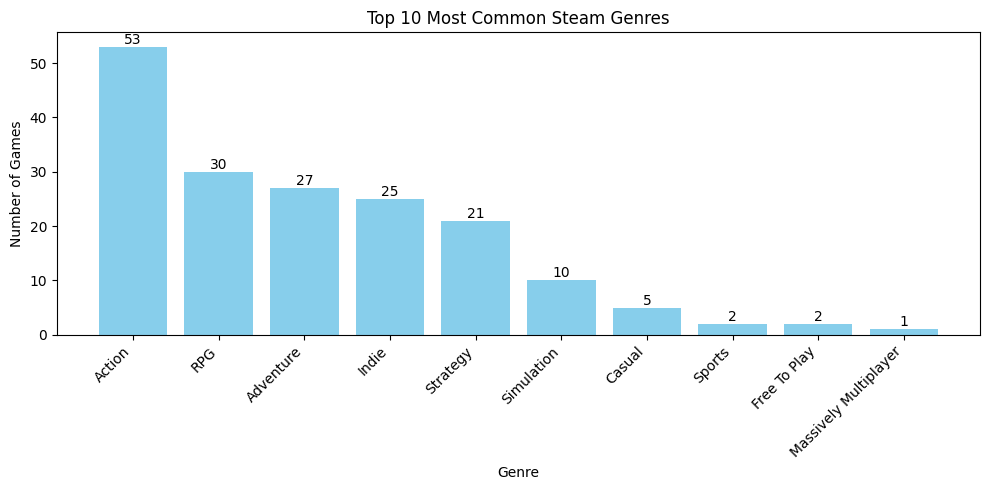

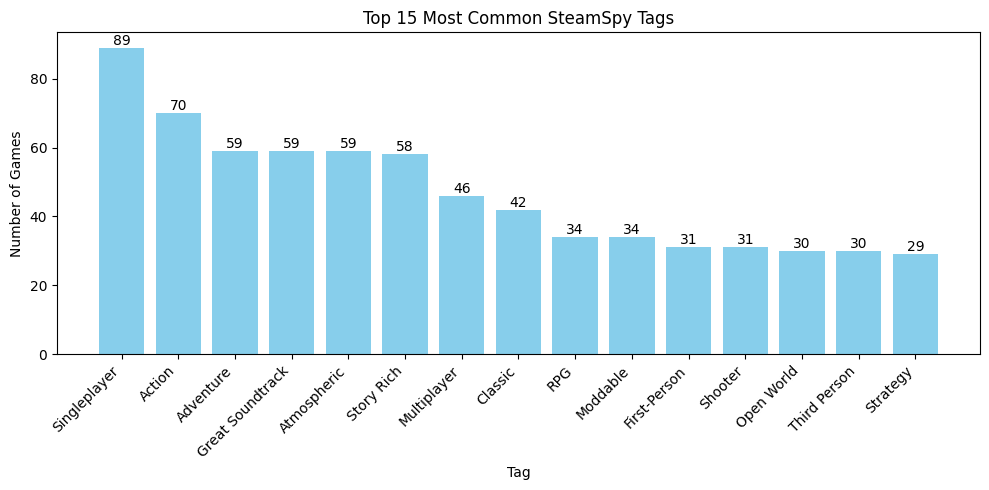

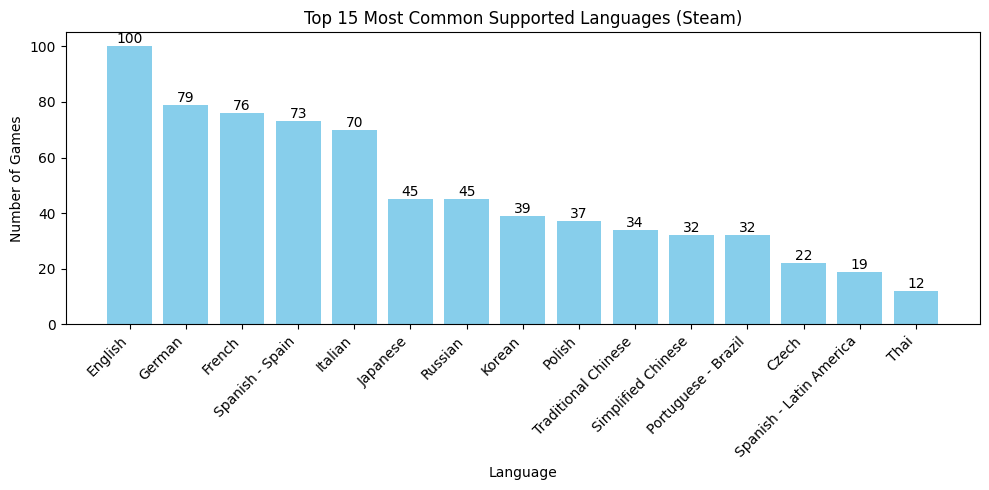

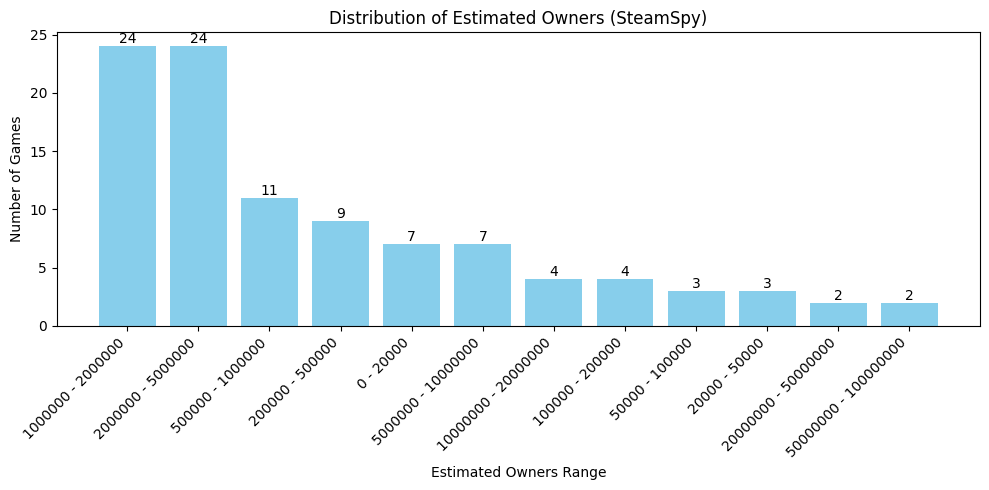

Displaying histogram: Distribution of Detailed Description Lengths (Steam)


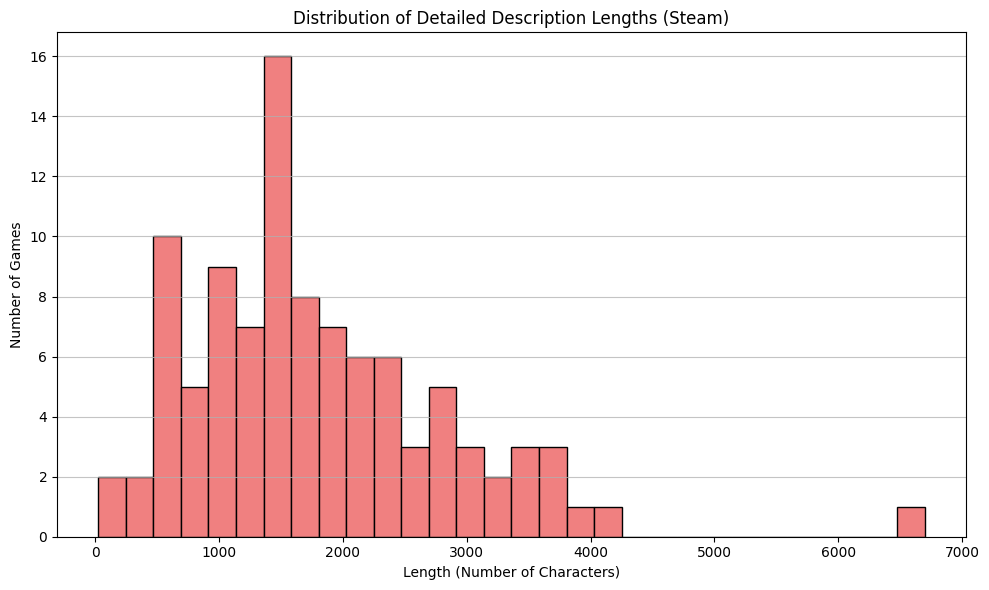

In [20]:
freq_distributions = calculate_frequency_distributions(steam_json, steamspy_json)

# Plot Top Steam Genres
plot_top_n_show(
    freq_distributions.get('steam_genres'),
    title="Top 10 Most Common Steam Genres",
    xlabel="Genre",
    ylabel="Number of Games",
    top_n=15
)

# Plot Top SteamSpy Tags
plot_top_n_show(
    freq_distributions.get('steamspy_tags'),
    title="Top 15 Most Common SteamSpy Tags",
    xlabel="Tag",
    ylabel="Number of Games",
    top_n=15
)

# Plot Top Supported Languages
plot_top_n_show(
    freq_distributions.get('steam_languages'),
    title="Top 15 Most Common Supported Languages (Steam)",
    xlabel="Language",
    ylabel="Number of Games",
    top_n=15
)

# Plot Estimated Owners Distribution
plot_top_n_show(
    freq_distributions.get('steamspy_owners'),
    title="Distribution of Estimated Owners (SteamSpy)",
    xlabel="Estimated Owners Range",
    ylabel="Number of Games",
    top_n=len(freq_distributions.get('steamspy_owners', {})) # Show all ranges
)

# Plot Description Length Histogram
description_lengths = [len(game.get('detailed_description', '')) for game in steam_json.values()]
plot_histogram_show(
    description_lengths,
    title="Distribution of Detailed Description Lengths (Steam)",
    xlabel="Length (Number of Characters)",
    ylabel="Number of Games",
    bins=30
)

In [21]:
def analyze_list_field_with_lengths(data_dict, field_name, dataset_name):
    list_lengths = []
    zero_count = 0
    total_entries = len(data_dict)

    for game_id, game_data in data_dict.items():
        items = game_data.get(field_name)
        count = 0

        if items is None:
            zero_count += 1
        elif isinstance(items, list):
            count = len(items)
            if count == 0:
                zero_count += 1
        else:
            zero_count += 1

        list_lengths.append(count) 

    if not list_lengths:
         return 0.0, 0.0, total_entries, []

    average_items = statistics.mean(list_lengths)
    percent_zero = (zero_count / total_entries) * 100.0 if total_entries > 0 else 0.0

    return average_items, percent_zero, total_entries, list_lengths

Displaying histogram: Distribution of Number of Screenshots per Game (Steam)


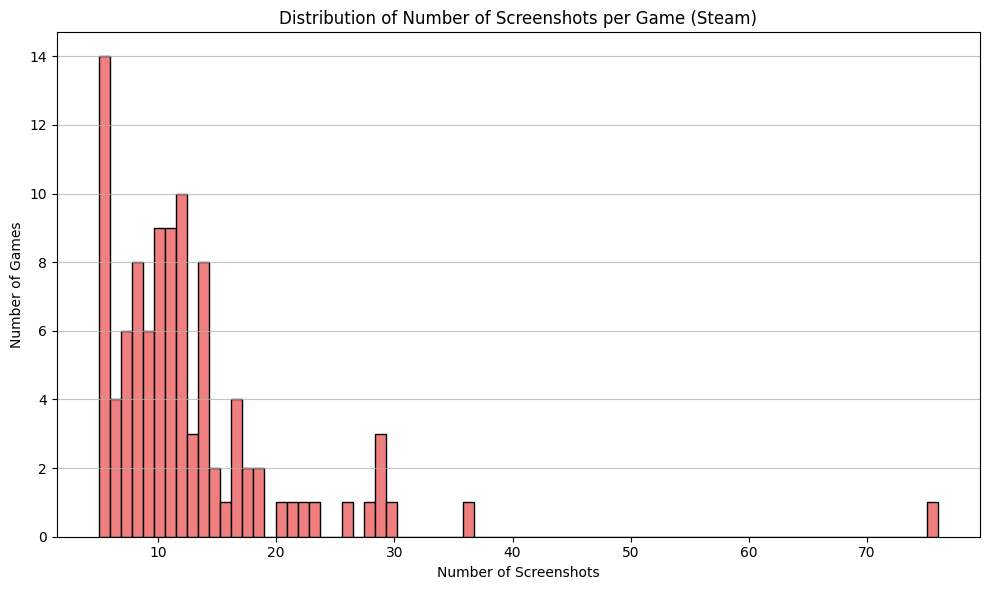

Displaying histogram: Distribution of Number of Movies per Game (Steam)


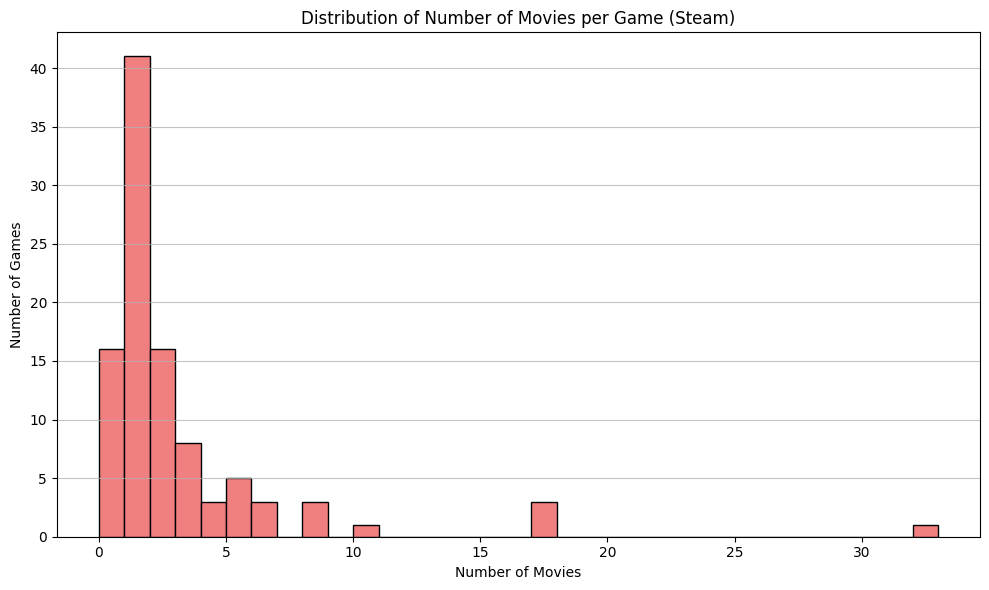

In [22]:
avg_screenshots, perc_zero_screenshots, total_checked_ss, screenshot_lengths = analyze_list_field_with_lengths(
    steam_json,
    'screenshots',
    "Steam"
)

plot_histogram_show(
    screenshot_lengths,
    title="Distribution of Number of Screenshots per Game (Steam)",
    xlabel="Number of Screenshots",
    ylabel="Number of Games",
    bins=max(1, max(screenshot_lengths) if screenshot_lengths else 1)
)

avg_movies, perc_zero_movies, total_checked_mov, movie_lengths = analyze_list_field_with_lengths(
    steam_json,
    'movies',
    "Steam"
)

plot_histogram_show(
    movie_lengths,
    title="Distribution of Number of Movies per Game (Steam)",
    xlabel="Number of Movies",
    ylabel="Number of Games",
    bins=range(max(movie_lengths) + 2) if movie_lengths else 1
)